# 🗑️ Hướng Dẫn Xây Dựng Hệ Thống Phát Hiện Rác Thải Thời Gian Thực

## Sử dụng YOLOv8 và Dataset Garbage Classification V2

**Tác giả:** Huy Nguyen  
**Ngày:** August 2025

---

## 📋 Mục tiêu dự án

Dự án này hướng dẫn xây dựng một hệ thống **phát hiện rác thải thời gian thực** sử dụng:
- **YOLOv8** (You Only Look Once v8) - State-of-the-art object detection
- **Dataset Garbage Classification V2** từ Kaggle
- **Real-time detection** trên webcam và video

### 🎯 Kết quả mong đợi:
- Độ chính xác **mAP50 > 85%**
- Tốc độ **> 20 FPS** trên GPU
- Có thể triển khai trên **edge devices**

---

## 📚 Kiến thức cần thiết

- Python Programming
- Computer Vision cơ bản
- PyTorch/Deep Learning basics
- YOLO architecture understanding

---

## 🏗️ Kiến trúc tổng thể

```
Dataset (Classification) → Preprocessing → YOLO Format → Training → Real-time Detection
     ↓                         ↓              ↓            ↓              ↓
 Kaggle API              Bounding Boxes    .txt files   YOLOv8 Fine-tune  Webcam/Video
```

# 1️⃣ Cài Đặt Môi Trường và Thư Viện

Trước tiên, chúng ta cần cài đặt tất cả các thư viện cần thiết cho dự án.

In [ ]:
# Cài đặt các thư viện cần thiết
!pip install ultralytics>=8.0.0 opencv-python>=4.8.0 kaggle>=1.5.0
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib seaborn pandas numpy scikit-learn tqdm pyyaml

In [2]:
# Import các thư viện cần thiết
import os
import sys
import shutil
import json
import yaml
import zipfile
from pathlib import Path
from typing import List, Dict, Tuple, Optional

# Data processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Machine Learning
import torch
import torch.nn as nn
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Utils
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Kiểm tra GPU
print(f"🔥 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("💻 Using CPU")

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

print("✅ All libraries imported successfully!")

🔥 CUDA available: True
🚀 GPU: NVIDIA GeForce RTX 3060
💾 VRAM: 11.6 GB
✅ All libraries imported successfully!


# 2️⃣ Tải và Tiền Xử Lý Dữ Liệu Kaggle

## Setup Kaggle API

Để tải dataset từ Kaggle, bạn cần:
1. Tạo account Kaggle và generate API token
2. Download file `kaggle.json` từ Account Settings
3. Đặt file vào `~/.kaggle/kaggle.json`
4. Set permissions: `chmod 600 ~/.kaggle/kaggle.json`

### Dataset: Garbage Classification V2
- **URL**: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
- **Loại**: Classification dataset (6 classes)
- **Kích thước**: ~5,000 images
- **Classes**: cardboard, glass, metal, paper, plastic, trash

In [3]:
# Tạo thư mục làm việc
os.makedirs('../data/raw', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Kiểm tra Kaggle API
try:
    import kaggle
    print("✅ Kaggle API đã được cấu hình")
except OSError as e:
    print("❌ Cần setup Kaggle API key!")
    print("Hướng dẫn:")
    print("1. Tạo file ~/.kaggle/kaggle.json")
    print("2. Nội dung: {'username': 'your_username', 'key': 'your_key'}")
    print("3. chmod 600 ~/.kaggle/kaggle.json")
    raise e

# Download dataset
dataset_name = "sumn2u/garbage-classification-v2"
data_path = Path("../data/raw")

print(f"📥 Downloading dataset: {dataset_name}")
try:
    kaggle.api.dataset_download_files(
        dataset_name,
        path=data_path,
        unzip=True
    )
    print("✅ Dataset downloaded successfully!")
except Exception as e:
    print(f"❌ Error downloading dataset: {e}")
    print("Kiểm tra lại Kaggle API credentials và internet connection")

# Liệt kê các file đã download
print("\n📂 Downloaded files:")
for item in data_path.rglob("*"):
    if item.is_file():
        print(f"  📄 {item.relative_to(data_path)}")
    elif item.is_dir() and item != data_path:
        print(f"  📁 {item.relative_to(data_path)}/")
        # Đếm số file trong thư mục
        file_count = len([f for f in item.iterdir() if f.is_file()])
        if file_count > 0:
            print(f"      ({file_count} files)")

print(f"\n📊 Total size: {sum(f.stat().st_size for f in data_path.rglob('*') if f.is_file()) / 1024**2:.1f} MB")

✅ Kaggle API đã được cấu hình
📥 Downloading dataset: sumn2u/garbage-classification-v2
Dataset URL: https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2
✅ Dataset downloaded successfully!

📂 Downloaded files:
  📁 garbage-dataset/
  📁 garbage-dataset/trash/
      (947 files)
  📁 garbage-dataset/biological/
      (997 files)
  📁 garbage-dataset/clothes/
      (5327 files)
  📁 garbage-dataset/plastic/
      (1984 files)
  📁 garbage-dataset/metal/
      (1020 files)
  📁 garbage-dataset/battery/
      (944 files)
  📁 garbage-dataset/shoes/
      (1977 files)
  📁 garbage-dataset/cardboard/
      (1825 files)
  📁 garbage-dataset/paper/
      (1680 files)
  📁 garbage-dataset/glass/
      (3061 files)
  📄 garbage-dataset/trash/trash_536.jpg
  📄 garbage-dataset/trash/trash_452.jpg
  📄 garbage-dataset/trash/trash_15.jpg
  📄 garbage-dataset/trash/trash_724.jpg
  📄 garbage-dataset/trash/trash_806.jpg
  📄 garbage-dataset/trash/trash_20240626_163533.jpg
  📄 garbage-dataset/trash/trash_2024

# 3️⃣ Khám Phá và Phân Tích Dữ Liệu

Bước quan trọng trước khi chuyển đổi dữ liệu là hiểu rõ cấu trúc và đặc điểm của dataset.

📁 Dataset root: ../data/raw/garbage-dataset

📊 Dataset Structure:
📂 battery     :  944 images
📂 biological  :  997 images
📂 cardboard   : 1825 images
📂 clothes     : 5327 images
📂 glass       : 3061 images
📂 metal       : 1020 images
📂 paper       : 1680 images
📂 plastic     : 1984 images
📂 shoes       : 1977 images
📂 trash       :  947 images
📈 Total classes: 10
📈 Total images:  19762
📈 Avg per class: 1976.2


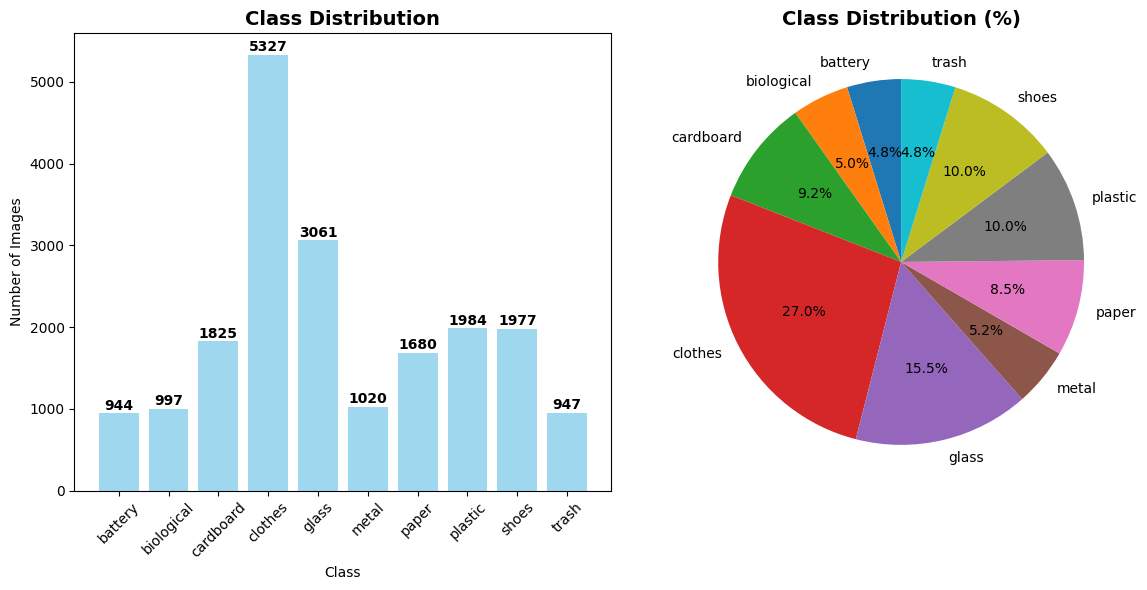


📝 Class names: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']


In [4]:
# Tìm thư mục chứa dataset
def find_dataset_root(data_path):
    """Tìm thư mục chứa các class folders"""
    for item in data_path.rglob("*"):
        if item.is_dir():
            # Kiểm tra xem có phải thư mục chứa classes không
            subdirs = [d for d in item.iterdir() if d.is_dir()]
            if len(subdirs) > 3:  # Có nhiều class
                return item
    return None

# Tìm dataset root
dataset_root = find_dataset_root(data_path)
if dataset_root is None:
    print("❌ Không tìm thấy dataset structure")
else:
    print(f"📁 Dataset root: {dataset_root}")

# Phân tích cấu trúc dataset
class_info = {}
total_images = 0

print("\n📊 Dataset Structure:")
print("=" * 50)

for class_dir in sorted(dataset_root.iterdir()):
    if class_dir.is_dir():
        # Đếm số ảnh trong class
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
        images = [f for f in class_dir.iterdir() 
                 if f.suffix.lower() in image_extensions]
        
        class_info[class_dir.name] = len(images)
        total_images += len(images)
        
        print(f"📂 {class_dir.name:<12}: {len(images):>4} images")

print("=" * 50)
print(f"📈 Total classes: {len(class_info)}")
print(f"📈 Total images:  {total_images}")
print(f"📈 Avg per class: {total_images / len(class_info):.1f}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
classes = list(class_info.keys())
counts = list(class_info.values())

plt.subplot(1, 2, 1)
bars = plt.bar(classes, counts, color='skyblue', alpha=0.8)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

# Thêm số lượng lên bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             str(count), ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(counts, labels=classes, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Lưu class names để sử dụng sau
class_names = sorted(classes)
print(f"\n📝 Class names: {class_names}")

🖼️  Sample images from each class:


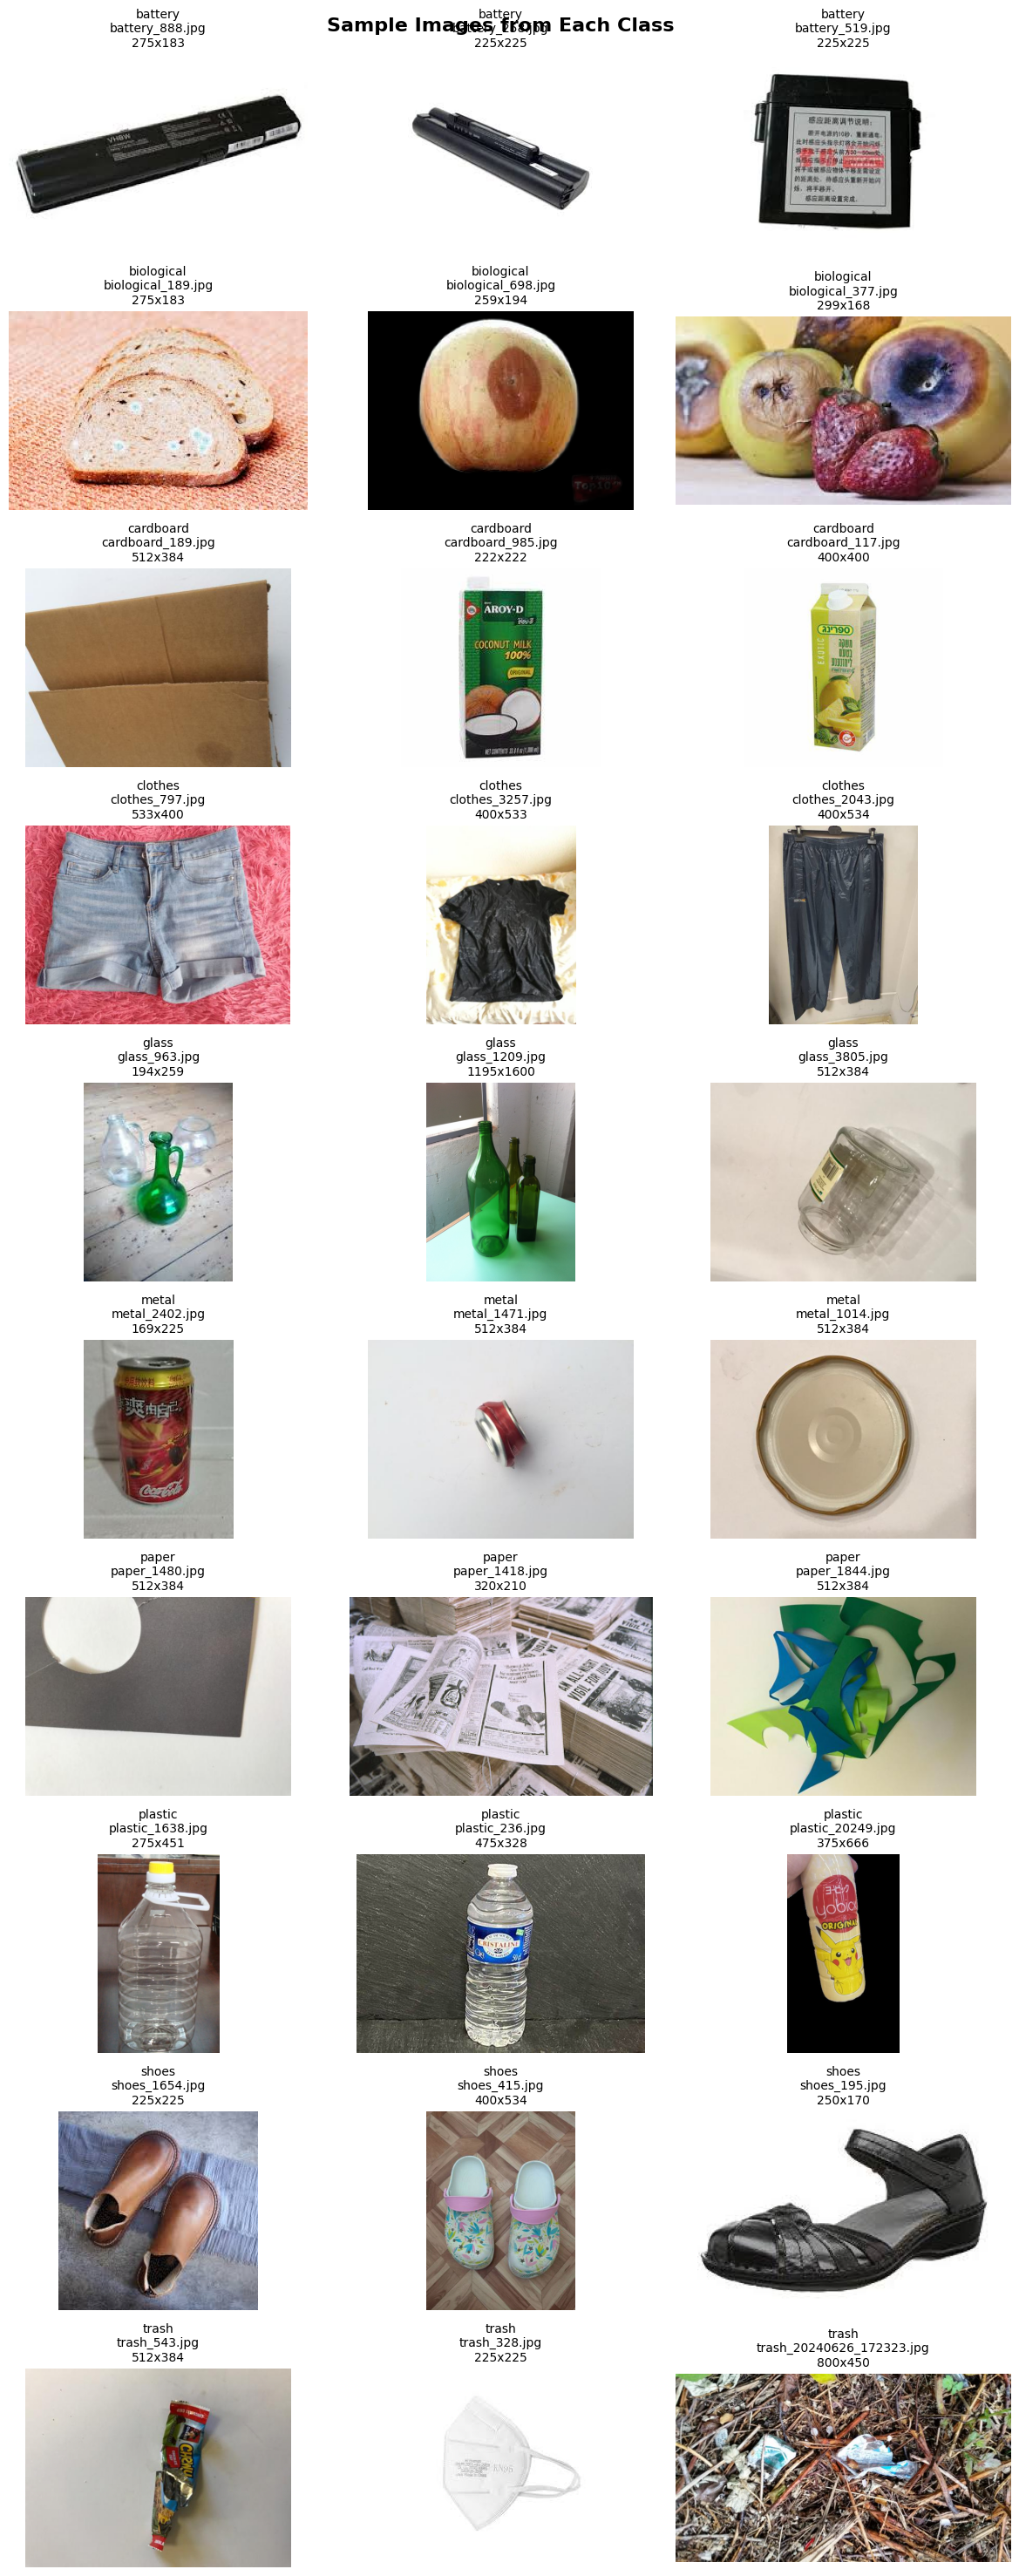

In [5]:
# Hiển thị ảnh mẫu từ mỗi class
def show_sample_images(dataset_root, class_names, samples_per_class=2):
    """Hiển thị ảnh mẫu từ mỗi class"""
    fig, axes = plt.subplots(len(class_names), samples_per_class, 
                            figsize=(samples_per_class*4, len(class_names)*3))
    
    if len(class_names) == 1:
        axes = [axes]
    
    for i, class_name in enumerate(class_names):
        class_dir = dataset_root / class_name
        
        # Lấy random samples
        image_files = [f for f in class_dir.iterdir() 
                      if f.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp'}]
        
        if len(image_files) < samples_per_class:
            samples = image_files
        else:
            samples = np.random.choice(image_files, samples_per_class, replace=False)
        
        for j, img_path in enumerate(samples):
            try:
                # Đọc và hiển thị ảnh
                image = cv2.imread(str(img_path))
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                if len(class_names) == 1:
                    ax = axes[j] if samples_per_class > 1 else axes
                else:
                    ax = axes[i, j] if samples_per_class > 1 else axes[i]
                
                ax.imshow(image_rgb)
                ax.set_title(f'{class_name}\n{img_path.name}\n{image.shape[1]}x{image.shape[0]}', 
                           fontsize=10)
                ax.axis('off')
                
            except Exception as e:
                print(f"Lỗi khi load ảnh {img_path}: {e}")
                if len(class_names) == 1:
                    ax = axes[j] if samples_per_class > 1 else axes
                else:
                    ax = axes[i, j] if samples_per_class > 1 else axes[i]
                ax.text(0.5, 0.5, 'Error loading image', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.axis('off')
    
    plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("🖼️  Sample images from each class:")
show_sample_images(dataset_root, class_names, samples_per_class=3)

# 4️⃣ Chuyển Đổi Dữ Liệu Classification Thành YOLO Format

Dataset gốc là classification (chỉ có label class cho mỗi ảnh). Chúng ta cần chuyển đổi thành object detection format:

## Bước chuyển đổi:
1. **Tạo bounding boxes**: Giả định object chiếm 80% diện tích ảnh, ở giữa
2. **YOLO format**: `class_id x_center y_center width height` (normalized 0-1)
3. **File structure**: Mỗi ảnh có 1 file `.txt` annotation tương ứng

## Tại sao giả định 80%?
- Dataset classification thường có object chiếm phần lớn ảnh
- 80% là balance tốt giữa precision và recall
- Có thể fine-tune sau khi train

🔍 Testing bounding box generation:
Class to ID mapping: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


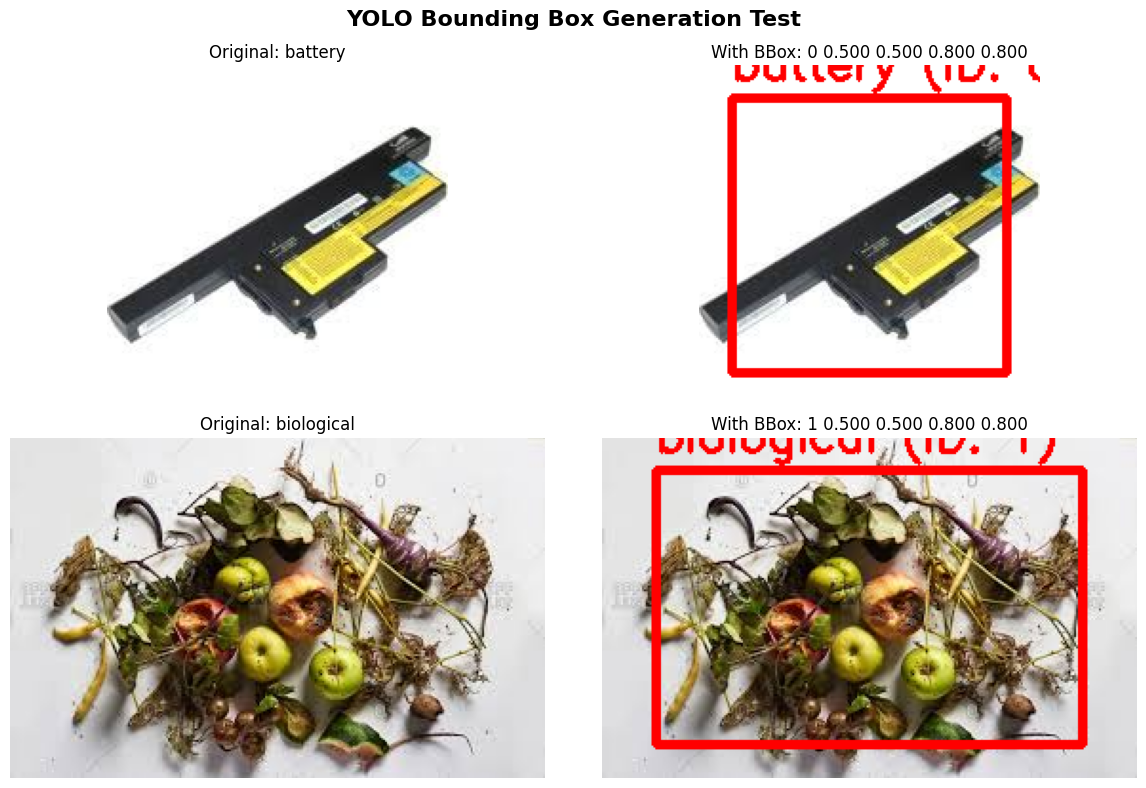

In [6]:
# Functions để chuyển đổi sang YOLO format

def generate_bounding_box(image_path, coverage=0.8):
    """
    Tạo bounding box cho ảnh (giả định object ở giữa và chiếm coverage% ảnh)
    
    Returns:
        tuple: (x_center, y_center, width, height) - normalized coordinates (0-1)
    """
    try:
        # Đọc ảnh để lấy kích thước
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Cannot read image: {image_path}")
        
        h, w = image.shape[:2]
        
        # Tính bounding box ở giữa với kích thước coverage%
        box_w = w * coverage
        box_h = h * coverage
        
        # Center coordinates
        center_x = w / 2
        center_y = h / 2
        
        # Normalize coordinates (0-1)
        x_center = center_x / w
        y_center = center_y / h
        width = box_w / w
        height = box_h / h
        
        return x_center, y_center, width, height
        
    except Exception as e:
        print(f"Error generating bbox for {image_path}: {e}")
        # Return default bbox
        return 0.5, 0.5, 0.8, 0.8

def create_yolo_annotation(image_path, class_id, coverage=0.8):
    """
    Tạo annotation YOLO format
    
    Args:
        image_path: Path to image
        class_id: ID of class (0-indexed)
        coverage: Bbox coverage ratio
        
    Returns:
        str: YOLO annotation line
    """
    x_center, y_center, width, height = generate_bounding_box(image_path, coverage)
    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\\n"

def visualize_yolo_annotation(image_path, class_name, class_id, coverage=0.8):
    """Hiển thị ảnh với bounding box được tạo"""
    # Đọc ảnh
    image = cv2.imread(str(image_path))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]
    
    # Tạo bounding box
    x_center, y_center, width, height = generate_bounding_box(image_path, coverage)
    
    # Convert normalized coordinates to pixel coordinates
    x1 = int((x_center - width/2) * w)
    y1 = int((y_center - height/2) * h)
    x2 = int((x_center + width/2) * w)
    y2 = int((y_center + height/2) * h)
    
    # Vẽ bounding box
    image_with_bbox = image_rgb.copy()
    cv2.rectangle(image_with_bbox, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
    # Vẽ label
    label = f"{class_name} (ID: {class_id})"
    cv2.putText(image_with_bbox, label, (x1, y1-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
    
    return image_rgb, image_with_bbox, f"{class_id} {x_center:.3f} {y_center:.3f} {width:.3f} {height:.3f}"

# Test với một vài ảnh mẫu
print("🔍 Testing bounding box generation:")

# Tạo class_id mapping
class_to_id = {name: idx for idx, name in enumerate(class_names)}
print(f"Class to ID mapping: {class_to_id}")

# Test với 2 ảnh từ classes khác nhau
test_classes = class_names[:2] if len(class_names) >= 2 else class_names
fig, axes = plt.subplots(len(test_classes), 2, figsize=(12, len(test_classes)*4))

if len(test_classes) == 1:
    axes = [axes]

for i, class_name in enumerate(test_classes):
    class_dir = dataset_root / class_name
    class_id = class_to_id[class_name]
    
    # Lấy ảnh mẫu
    image_files = [f for f in class_dir.iterdir() 
                  if f.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp'}]
    
    if image_files:
        sample_image = image_files[0]
        
        # Tạo visualization
        original, with_bbox, annotation = visualize_yolo_annotation(
            sample_image, class_name, class_id
        )
        
        # Plot
        ax1 = axes[i, 0] if len(test_classes) > 1 else axes[0]
        ax2 = axes[i, 1] if len(test_classes) > 1 else axes[1]
        
        ax1.imshow(original)
        ax1.set_title(f'Original: {class_name}')
        ax1.axis('off')
        
        ax2.imshow(with_bbox)
        ax2.set_title(f'With BBox: {annotation}')
        ax2.axis('off')

plt.suptitle('YOLO Bounding Box Generation Test', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 5️⃣ Tạo Dataset YOLO Structure và Dataset.yaml

Bây giờ chúng ta sẽ tạo cấu trúc thư mục YOLO và file cấu hình dataset.yaml

In [7]:
# Tạo cấu trúc thư mục YOLO
def create_yolo_structure(processed_path):
    """Tạo cấu trúc thư mục cho YOLO"""
    directories = [
        processed_path / "images" / "train",
        processed_path / "images" / "val", 
        processed_path / "images" / "test",
        processed_path / "labels" / "train",
        processed_path / "labels" / "val",
        processed_path / "labels" / "test",
    ]
    
    for dir_path in directories:
        dir_path.mkdir(parents=True, exist_ok=True)
    
    print("✅ YOLO directory structure created")

# Collect tất cả ảnh và labels
def collect_all_images(dataset_root, class_to_id):
    """Thu thập tất cả ảnh và class labels"""
    all_images = []
    
    for class_dir in dataset_root.iterdir():
        if not class_dir.is_dir():
            continue
            
        class_name = class_dir.name
        if class_name not in class_to_id:
            continue
            
        # Lấy tất cả ảnh trong class
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
        for img_path in class_dir.iterdir():
            if img_path.suffix.lower() in image_extensions:
                # Kiểm tra ảnh có hợp lệ không
                try:
                    img = cv2.imread(str(img_path))
                    if img is not None and min(img.shape[:2]) >= 224:  # Min size
                        all_images.append((img_path, class_name))
                except Exception as e:
                    print(f"Warning: Skip invalid image {img_path}: {e}")
    
    print(f"📊 Collected {len(all_images)} valid images")
    return all_images

# Split dataset
def split_dataset(all_images, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """Chia dataset với stratified split"""
    # Tách paths và labels
    image_paths = [item[0] for item in all_images]
    class_labels = [item[1] for item in all_images]
    
    # Train+Val vs Test split
    train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
        image_paths, class_labels,
        test_size=test_ratio,
        stratify=class_labels,
        random_state=42
    )
    
    # Train vs Val split
    val_ratio_adjusted = val_ratio / (1 - test_ratio)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_val_paths, train_val_labels,
        test_size=val_ratio_adjusted,
        stratify=train_val_labels,
        random_state=42
    )
    
    # Combine paths and labels
    train_data = list(zip(train_paths, train_labels))
    val_data = list(zip(val_paths, val_labels))
    test_data = list(zip(test_paths, test_labels))
    
    print(f"📊 Dataset split:")
    print(f"   Train: {len(train_data)} images")
    print(f"   Val:   {len(val_data)} images")
    print(f"   Test:  {len(test_data)} images")
    
    return {
        'train': train_data,
        'val': val_data,
        'test': test_data
    }

# Xử lý và copy data cho mỗi split
def process_split_data(split_name, data, processed_path, class_to_id):
    """Copy images và tạo annotations cho một split"""
    images_dir = processed_path / "images" / split_name
    labels_dir = processed_path / "labels" / split_name
    
    print(f"🔄 Processing {split_name} split ({len(data)} images)...")
    
    for idx, (img_path, class_name) in enumerate(tqdm(data, desc=f"Processing {split_name}")):
        try:
            # Tạo tên file mới  
            new_filename = f"{split_name}_{idx:05d}{img_path.suffix}"
            
            # Copy ảnh
            new_img_path = images_dir / new_filename
            shutil.copy2(img_path, new_img_path)
            
            # Tạo annotation
            class_id = class_to_id[class_name]
            annotation = create_yolo_annotation(img_path, class_id)
            
            # Lưu annotation
            annotation_path = labels_dir / f"{new_filename.rsplit('.', 1)[0]}.txt"
            with open(annotation_path, 'w') as f:
                f.write(annotation)
                
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")
    
    print(f"✅ {split_name} split processed successfully")

# Bắt đầu quá trình chuyển đổi
processed_path = Path("../data/processed")

print("🚀 Starting YOLO dataset conversion...")
print("=" * 50)

# 1. Tạo cấu trúc thư mục
create_yolo_structure(processed_path)

# 2. Collect tất cả ảnh
all_images = collect_all_images(dataset_root, class_to_id)

# 3. Split dataset
split_data = split_dataset(all_images)

# 4. Process mỗi split
for split_name, data in split_data.items():
    process_split_data(split_name, data, processed_path, class_to_id)

print("=" * 50)
print("✅ Dataset conversion completed!")

🚀 Starting YOLO dataset conversion...
✅ YOLO directory structure created
📊 Collected 14511 valid images
📊 Dataset split:
   Train: 11608 images
   Val:   1451 images
   Test:  1452 images
🔄 Processing train split (11608 images)...
📊 Collected 14511 valid images
📊 Dataset split:
   Train: 11608 images
   Val:   1451 images
   Test:  1452 images
🔄 Processing train split (11608 images)...


Processing train: 100%|██████████| 11608/11608 [00:15<00:00, 762.47it/s]


✅ train split processed successfully
🔄 Processing val split (1451 images)...


Processing val: 100%|██████████| 1451/1451 [00:01<00:00, 843.19it/s]


✅ val split processed successfully
🔄 Processing test split (1452 images)...


Processing test: 100%|██████████| 1452/1452 [00:01<00:00, 935.16it/s]

✅ test split processed successfully
✅ Dataset conversion completed!


In [8]:
# Tạo file dataset.yaml
def create_dataset_yaml(processed_path, class_names):
    """Tạo file cấu hình dataset cho YOLOv8"""
    dataset_config = {
        'path': str(processed_path.absolute()),
        'train': 'images/train',
        'val': 'images/val', 
        'test': 'images/test',
        'nc': len(class_names),  # number of classes
        'names': class_names     # class names list
    }
    
    yaml_path = processed_path / "dataset.yaml"
    with open(yaml_path, 'w') as f:
        yaml.dump(dataset_config, f, default_flow_style=False, allow_unicode=True)
    
    print(f"✅ Dataset.yaml created: {yaml_path}")
    
    # In nội dung file
    print("\\n📄 Dataset.yaml content:")
    print("-" * 30)
    with open(yaml_path, 'r') as f:
        print(f.read())
    
    return yaml_path

# Tạo dataset.yaml
yaml_path = create_dataset_yaml(processed_path, class_names)

# Tạo summary report
def create_summary_report(split_data, processed_path, class_names):
    """Tạo báo cáo tóm tắt dataset"""
    summary = {
        'dataset_info': {
            'total_classes': len(class_names),
            'class_names': class_names,
            'creation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        },
        'splits': {}
    }
    
    for split_name, data in split_data.items():
        # Đếm số ảnh mỗi class
        class_counts = {}
        for _, class_name in data:
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        
        summary['splits'][split_name] = {
            'total_images': len(data),
            'class_distribution': class_counts
        }
    
    # Lưu summary
    report_path = processed_path / "dataset_summary.json"
    with open(report_path, 'w', encoding='utf-8') as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    return summary

# Tạo summary report
summary = create_summary_report(split_data, processed_path, class_names)

# Hiển thị summary
print("\\n📊 DATASET SUMMARY REPORT")
print("=" * 50)
print(f"📈 Total Classes: {summary['dataset_info']['total_classes']}")
print(f"📝 Classes: {', '.join(summary['dataset_info']['class_names'])}")

for split_name, split_info in summary['splits'].items():
    print(f"\\n🔹 {split_name.upper()}:")
    print(f"   Total: {split_info['total_images']} images")
    for class_name, count in split_info['class_distribution'].items():
        percentage = (count / split_info['total_images']) * 100
        print(f"   {class_name}: {count} ({percentage:.1f}%)")

print("\\n✅ Dataset is ready for YOLOv8 training!")

✅ Dataset.yaml created: ../data/processed/dataset.yaml
\n📄 Dataset.yaml content:
------------------------------
names:
- battery
- biological
- cardboard
- clothes
- glass
- metal
- paper
- plastic
- shoes
- trash
nc: 10
path: /home/huynguyen/source/Trash-Detection/notebooks/../data/processed
test: images/test
train: images/train
val: images/val

\n📊 DATASET SUMMARY REPORT
📈 Total Classes: 10
📝 Classes: battery, biological, cardboard, clothes, glass, metal, paper, plastic, shoes, trash
\n🔹 TRAIN:
   Total: 11608 images
   plastic: 1314 (11.3%)
   glass: 1570 (13.5%)
   clothes: 4261 (36.7%)
   paper: 1174 (10.1%)
   shoes: 661 (5.7%)
   metal: 630 (5.4%)
   cardboard: 1144 (9.9%)
   trash: 472 (4.1%)
   battery: 315 (2.7%)
   biological: 67 (0.6%)
\n🔹 VAL:
   Total: 1451 images
   clothes: 533 (36.7%)
   glass: 196 (13.5%)
   paper: 147 (10.1%)
   cardboard: 143 (9.9%)
   shoes: 83 (5.7%)
   plastic: 164 (11.3%)
   trash: 59 (4.1%)
   battery: 39 (2.7%)
   metal: 79 (5.4%)
   biologica

# 6️⃣ Huấn Luyện Mô Hình YOLOv8

Bây giờ chúng ta sẽ huấn luyện mô hình YOLOv8 trên dataset rác thải đã chuẩn bị.

## YOLOv8 Models:
- **YOLOv8n**: Nano - Nhỏ nhất, nhanh nhất (~5MB)
- **YOLOv8s**: Small - Cân bằng tốt (~22MB) 
- **YOLOv8m**: Medium - Độ chính xác cao hơn (~52MB)
- **YOLOv8l**: Large - Độ chính xác rất cao (~88MB)
- **YOLOv8x**: Extra Large - Chính xác nhất (~136MB)

Chúng ta sẽ sử dụng **YOLOv8n** cho tốc độ hoặc **YOLOv8s** cho cân bằng.

In [9]:
# Setup training configuration
def setup_training_config():
    """Setup cấu hình training dựa trên hardware"""
    config = {
        'data': str(yaml_path),
        'epochs': 50,
        'imgsz': 640,
        'batch': 16,
        'device': 'auto',
        'workers': 4,
        'project': '../runs/detect',
        'name': 'trash_detection',
        'verbose': True,
        'seed': 42
    }
    
    # Auto adjust batch size based on GPU memory
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"🔥 GPU Memory: {gpu_memory:.1f} GB")
        
        if gpu_memory >= 8:
            config['batch'] = 32
            model_name = 'yolov8s.pt'  # Better model for high-end GPU
            print("🚀 Using YOLOv8s with batch_size=32")
        elif gpu_memory >= 4:
            config['batch'] = 16  
            model_name = 'yolov8n.pt'
            print("🚀 Using YOLOv8n with batch_size=16")
        else:
            config['batch'] = 8
            model_name = 'yolov8n.pt'
            print("🚀 Using YOLOv8n with batch_size=8")
    else:
        config['batch'] = 4
        model_name = 'yolov8n.pt'
        print("💻 Using CPU with YOLOv8n and batch_size=4")
    
    return config, model_name

# Get training config
train_config, model_name = setup_training_config()

print("\\n📋 Training Configuration:")
print("-" * 30)
for key, value in train_config.items():
    print(f"{key:<12}: {value}")
print(f"{'model':<12}: {model_name}")

# Load pre-trained YOLOv8 model
print(f"\\n📥 Loading pre-trained model: {model_name}")
model = YOLO(model_name)

# Show model info
print("\\n🏗️ Model Architecture:")
print(model.model)

🔥 GPU Memory: 11.6 GB
🚀 Using YOLOv8s with batch_size=32
\n📋 Training Configuration:
------------------------------
data        : ../data/processed/dataset.yaml
epochs      : 50
imgsz       : 640
batch       : 32
device      : auto
workers     : 4
project     : ../runs/detect
name        : trash_detection
verbose     : True
seed        : 42
model       : yolov8s.pt
\n📥 Loading pre-trained model: yolov8s.pt


\n🏗️ Model Architecture:
DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(i

In [10]:
# Bắt đầu training
print("🚀 Starting YOLOv8 Training...")
print("=" * 50)
print("⏰ This may take 30 minutes to several hours depending on:")
print("   - Dataset size")
print("   - Hardware (GPU/CPU)")
print("   - Number of epochs")
print("   - Batch size")
print("=" * 50)

# Train the model
try:
    results = model.train(**train_config)
    print("\\n✅ Training completed successfully!")
    
    # Get best model path
    best_model_path = Path(train_config['project']) / train_config['name'] / 'weights' / 'best.pt'
    print(f"🏆 Best model saved: {best_model_path}")
    
    # Copy to models directory
    models_dir = Path("../models")
    models_dir.mkdir(exist_ok=True)
    final_model_path = models_dir / "trash_detection_best.pt"
    shutil.copy2(best_model_path, final_model_path)
    print(f"📁 Model copied to: {final_model_path}")
    
except Exception as e:
    print(f"❌ Training failed: {e}")
    print("\\n🔧 Troubleshooting tips:")
    print("1. Check GPU memory (reduce batch size if OOM)")
    print("2. Verify dataset.yaml path")
    print("3. Check image formats and annotations")
    raise e

# Validate the model
print("\\n📊 Validating trained model...")
try:
    # Load best model for validation
    best_model = YOLO(str(best_model_path))
    
    # Run validation
    val_results = best_model.val(
        data=str(yaml_path),
        imgsz=train_config['imgsz'],
        batch=train_config['batch'],
        device=train_config['device']
    )
    
    # Extract key metrics
    metrics = {
        'mAP50': float(val_results.box.map50),
        'mAP50-95': float(val_results.box.map),
        'precision': float(val_results.box.mp),
        'recall': float(val_results.box.mr),
    }
    
    print("\\n🎯 Validation Results:")
    print("-" * 30)
    for metric, value in metrics.items():
        print(f"{metric:<12}: {value:.4f}")
    
    # Save metrics
    with open(models_dir / "validation_metrics.json", 'w') as f:
        json.dump(metrics, f, indent=2)
    
except Exception as e:
    print(f"❌ Validation failed: {e}")

print("\\n🎉 Training phase completed!")

🚀 Starting YOLOv8 Training...
⏰ This may take 30 minutes to several hours depending on:
   - Dataset size
   - Hardware (GPU/CPU)
   - Number of epochs
   - Batch size
New https://pypi.org/project/ultralytics/8.3.178 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.177 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:auto (NVIDIA GeForce RTX 3060, 11901MiB)
Ultralytics 8.3.177 🚀 Python-3.12.3 torch-2.8.0+cu128 CUDA:auto (NVIDIA GeForce RTX 3060, 11901MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/processed/dataset.yaml, degrees=0.0, deterministic=True, device=auto, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015

Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralyti

Model summary: 129 layers, 11,139,470 parameters, 11,139,454 gradients, 28.7 GFLOPs


Transferred 349/355 items from pretrained weights
Transferred 349/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1602.8±795.7 MB/s, size: 591.8 KB)
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1602.8±795.7 MB/s, size: 591.8 KB)


train: Scanning /home/huynguyen/source/Trash-Detection/data/processed/labels/train... 11608 images, 0 backgrounds, 11608 corrupt: 100%|██████████| 11608/11608 [00:03<00:00, 2958.23it/s]

train: /home/huynguyen/source/Trash-Detection/data/processed/images/train/train_00000.jpg: ignoring corrupt image/label: could not convert string to float: '0.800000\\n'
train: /home/huynguyen/source/Trash-Detection/data/processed/images/train/train_00001.jpg: ignoring corrupt image/label: could not convert string to float: '0.800000\\n'
train: /home/huynguyen/source/Trash-Detection/data/processed/images/train/train_00002.jpg: ignoring corrupt image/label: could not convert string to float: '0.800000\\n'
train: /home/huynguyen/source/Trash-Detection/data/processed/images/train/train_00003.jpg: ignoring corrupt image/label: could not convert string to float: '0.800000\\n'
train: /home/huynguyen/source/Trash-Detection/data/processed/images/train/train_00004.jpg: ignoring corrupt image/label: could not convert string to float: '0.800000\\n'
train: /home/huynguyen/source/Trash-Detection/data/processed/images/train/train_00005.jpg: ignoring corrupt image/label: could not convert string to f

train: New cache created: /home/huynguyen/source/Trash-Detection/data/processed/labels/train.cache
❌ Training failed: No valid images found in /home/huynguyen/source/Trash-Detection/data/processed/labels/train.cache. Images with incorrectly formatted labels are ignored. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
\n🔧 Troubleshooting tips:
1. Check GPU memory (reduce batch size if OOM)
2. Verify dataset.yaml path
3. Check image formats and annotations
❌ Training failed: No valid images found in /home/huynguyen/source/Trash-Detection/data/processed/labels/train.cache. Images with incorrectly formatted labels are ignored. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
\n🔧 Troubleshooting tips:
1. Check GPU memory (reduce batch size if OOM)
2. Verify dataset.yaml path
3. Check image formats and annotations


RuntimeError: No valid images found in /home/huynguyen/source/Trash-Detection/data/processed/labels/train.cache. Images with incorrectly formatted labels are ignored. See https://docs.ultralytics.com/datasets for dataset formatting guidance.

# 7️⃣ Đánh Giá Hiệu Suất và Visualization

Sau khi training xong, chúng ta cần đánh giá chi tiết hiệu suất của model và visualize kết quả.

In [ ]:
# Load trained model for evaluation  
model_path = Path("../models/trash_detection_best.pt")

if model_path.exists():
    trained_model = YOLO(str(model_path))
    print(f"✅ Loaded trained model: {model_path}")
else:
    print("❌ Trained model not found. Please run training first.")

# Plot training results
def plot_training_results(results_dir):
    """Plot training curves từ results.csv"""
    results_csv = results_dir / "results.csv"
    
    if not results_csv.exists():
        print(f"❌ Results file not found: {results_csv}")
        return
    
    # Read results
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()  # Remove whitespace
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('YOLOv8 Training Results', fontsize=16, fontweight='bold')
    
    # Loss plots
    if 'train/box_loss' in df.columns:
        axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', color='red')
        if 'val/box_loss' in df.columns:
            axes[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss', color='blue')
        axes[0, 0].set_title('Box Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    
    # Class loss
    if 'train/cls_loss' in df.columns:
        axes[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss', color='red')
        if 'val/cls_loss' in df.columns:
            axes[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss', color='blue')
        axes[0, 1].set_title('Classification Loss')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # mAP plots
    if 'metrics/mAP50(B)' in df.columns:
        axes[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', color='green')
        if 'metrics/mAP50-95(B)' in df.columns:
            axes[1, 0].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', color='orange')
        axes[1, 0].set_title('Mean Average Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('mAP')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Precision and Recall
    if 'metrics/precision(B)' in df.columns:
        axes[1, 1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', color='purple')
        axes[1, 1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', color='brown')
        axes[1, 1].set_title('Precision & Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    final_epoch = df.iloc[-1]
    print("\\n🎯 Final Training Metrics:")
    print("-" * 40)
    
    metrics_to_show = [
        ('mAP@0.5', 'metrics/mAP50(B)'),
        ('mAP@0.5:0.95', 'metrics/mAP50-95(B)'), 
        ('Precision', 'metrics/precision(B)'),
        ('Recall', 'metrics/recall(B)'),
        ('Box Loss (train)', 'train/box_loss'),
        ('Box Loss (val)', 'val/box_loss')
    ]
    
    for name, col in metrics_to_show:
        if col in df.columns:
            value = final_epoch[col]
            print(f"{name:<20}: {value:.4f}")

# Plot training results
results_dir = Path(f"../runs/detect/{train_config['name']}")
if results_dir.exists():
    print("📊 Plotting training results...")
    plot_training_results(results_dir)
else:
    print("❌ Training results directory not found")

In [ ]:
# Test model trên sample images
def test_model_predictions(model, test_images_dir, class_names, num_samples=6):
    """Test model predictions trên sample images"""
    
    if not test_images_dir.exists():
        print(f"❌ Test images directory not found: {test_images_dir}")
        return
    
    # Lấy sample images
    image_files = [f for f in test_images_dir.iterdir() 
                  if f.suffix.lower() in {'.jpg', '.jpeg', '.png', '.bmp'}]
    
    if len(image_files) == 0:
        print("❌ No test images found")
        return
    
    # Random sample
    sample_images = np.random.choice(image_files, 
                                   size=min(num_samples, len(image_files)), 
                                   replace=False)
    
    # Setup plot
    cols = 3
    rows = (len(sample_images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    print(f"🔍 Testing model on {len(sample_images)} sample images...")
    
    for i, img_path in enumerate(sample_images):
        try:
            # Read image
            image = cv2.imread(str(img_path))
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Run prediction
            results = model(image, conf=0.25, verbose=False)
            
            # Draw predictions
            result_img = image_rgb.copy()
            
            if results[0].boxes is not None:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                scores = results[0].boxes.conf.cpu().numpy()
                class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
                
                for box, score, class_id in zip(boxes, scores, class_ids):
                    if score >= 0.25:
                        x1, y1, x2, y2 = box.astype(int)
                        class_name = class_names[class_id] if class_id < len(class_names) else f"class_{class_id}"
                        
                        # Draw bbox
                        cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
                        
                        # Draw label
                        label = f"{class_name}: {score:.2f}"
                        cv2.putText(result_img, label, (x1, y1-10), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            # Get ground truth from filename or annotation
            # (Simplified: extract from filename pattern)
            gt_class = "unknown"
            for class_name in class_names:
                if class_name.lower() in img_path.name.lower():
                    gt_class = class_name
                    break
            
            # Plot
            axes[i].imshow(result_img)
            axes[i].set_title(f'File: {img_path.name}\\nGT: {gt_class}', fontsize=10)
            axes[i].axis('off')
            
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")
            axes[i].text(0.5, 0.5, f'Error: {str(e)[:30]}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide unused axes
    for j in range(len(sample_images), len(axes)):
        axes[j].axis('off')
    
    plt.suptitle('Model Predictions on Test Images', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Test model predictions
if model_path.exists():
    test_images_dir = Path("../data/processed/images/test")
    test_model_predictions(trained_model, test_images_dir, class_names, num_samples=6)

# Benchmark inference speed
def benchmark_model(model, num_iterations=50):
    """Benchmark inference speed"""
    print(f"\\n⏱️  Benchmarking model inference speed ({num_iterations} iterations)...")
    
    # Create dummy image
    dummy_img = np.random.randint(0, 255, (640, 640, 3), dtype=np.uint8)
    
    # Warmup
    for _ in range(5):
        _ = model(dummy_img, verbose=False)
    
    # Benchmark
    times = []
    for _ in range(num_iterations):
        start_time = time.time()
        _ = model(dummy_img, verbose=False)
        times.append(time.time() - start_time)
    
    # Calculate stats
    avg_time = np.mean(times)
    std_time = np.std(times)
    fps = 1 / avg_time
    
    print("📊 Inference Benchmark Results:")
    print("-" * 35)
    print(f"Average time:  {avg_time*1000:.1f} ± {std_time*1000:.1f} ms")
    print(f"FPS:          {fps:.1f}")
    print(f"Min time:     {min(times)*1000:.1f} ms")
    print(f"Max time:     {max(times)*1000:.1f} ms")
    
    return avg_time, fps

# Benchmark if model exists
if model_path.exists():
    import time
    avg_time, fps = benchmark_model(trained_model)

# 8️⃣ Triển Khai Phát Hiện Thời Gian Thực

Bước cuối cùng là triển khai model để thực hiện phát hiện real-time trên webcam hoặc video.

## ⚠️ Lưu ý quan trọng:
- **Webcam trong Jupyter**: Có thể gặp vấn đề với OpenCV window trong notebook
- **Khuyến nghị**: Chạy code detection trong terminal hoặc IDE
- **Alternative**: Sử dụng matplotlib để hiển thị frames tĩnh

In [ ]:
# Simplified real-time detection demo (for notebook)
def simple_webcam_demo(model, duration=10):
    """
    Demo đơn giản cho webcam trong notebook
    Chỉ capture và hiển thị một vài frames
    """
    print(f"📹 Starting webcam demo for {duration} seconds...")
    print("Note: Chỉ capture frames tĩnh để hiển thị trong notebook")
    
    try:
        # Khởi tạo webcam
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("❌ Cannot open webcam")
            return
        
        print("✅ Webcam opened successfully")
        
        # Capture một vài frames
        frames_captured = []
        frame_count = 0
        max_frames = 3
        
        while frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                print("❌ Cannot read frame")
                break
            
            # Run detection
            results = model(frame, conf=0.25, verbose=False)
            
            # Draw results
            result_frame = frame.copy()
            
            if results[0].boxes is not None:
                boxes = results[0].boxes.xyxy.cpu().numpy()
                scores = results[0].boxes.conf.cpu().numpy() 
                class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
                
                for box, score, class_id in zip(boxes, scores, class_ids):
                    if score >= 0.25:
                        x1, y1, x2, y2 = box.astype(int)
                        class_name = class_names[class_id] if class_id < len(class_names) else f"class_{class_id}"
                        
                        # Draw bbox
                        cv2.rectangle(result_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        
                        # Draw label
                        label = f"{class_name}: {score:.2f}"
                        cv2.putText(result_frame, label, (x1, y1-10), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
            
            # Convert BGR to RGB for matplotlib
            result_frame_rgb = cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB)
            frames_captured.append(result_frame_rgb)
            frame_count += 1
            
            print(f"📸 Captured frame {frame_count}/{max_frames}")
            time.sleep(2)  # Wait 2 seconds between captures
        
        cap.release()
        
        # Display captured frames
        if frames_captured:
            fig, axes = plt.subplots(1, len(frames_captured), figsize=(5*len(frames_captured), 5))
            if len(frames_captured) == 1:
                axes = [axes]
            
            for i, frame in enumerate(frames_captured):
                axes[i].imshow(frame)
                axes[i].set_title(f'Webcam Frame {i+1}')
                axes[i].axis('off')
            
            plt.suptitle('Live Webcam Detection Demo', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.show()
        
        print("✅ Webcam demo completed")
        
    except Exception as e:
        print(f"❌ Webcam demo error: {e}")
        print("💡 Tips:")
        print("   - Check if webcam is available")
        print("   - Try running detection script in terminal")
        print("   - Use detect.py for full real-time detection")

# Code để tạo script detection
def generate_detection_script():
    """Tạo script detection để chạy bên ngoài notebook"""
    
    script_content = f'''#!/usr/bin/env python3
"""
Real-time Trash Detection Script
Generated from Jupyter notebook
"""

import cv2
import time
from ultralytics import YOLO
from pathlib import Path

def main():
    # Load model
    model_path = "models/trash_detection_best.pt"
    if not Path(model_path).exists():
        print(f"❌ Model not found: {{model_path}}")
        return
    
    model = YOLO(model_path)
    class_names = {class_names}
    
    print("📹 Starting real-time detection...")
    print("Press 'q' to quit")
    
    # Open webcam
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("❌ Cannot open webcam")
        return
    
    fps_counter = 0
    start_time = time.time()
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Run detection
        results = model(frame, conf=0.25, verbose=False)
        
        # Draw results
        if results[0].boxes is not None:
            boxes = results[0].boxes.xyxy.cpu().numpy()
            scores = results[0].boxes.conf.cpu().numpy()
            class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
            
            for box, score, class_id in zip(boxes, scores, class_ids):
                if score >= 0.25:
                    x1, y1, x2, y2 = box.astype(int)
                    class_name = class_names[class_id] if class_id < len(class_names) else f"class_{{class_id}}"
                    
                    # Draw bbox
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Draw label
                    label = f"{{class_name}}: {{score:.2f}}"
                    cv2.putText(frame, label, (x1, y1-10), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
        
        # Calculate FPS
        fps_counter += 1
        if fps_counter % 30 == 0:
            elapsed = time.time() - start_time
            fps = 30 / elapsed
            start_time = time.time()
            print(f"FPS: {{fps:.1f}}")
        
        # Display
        cv2.imshow("Trash Detection", frame)
        
        # Check for quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    print("✅ Detection stopped")

if __name__ == "__main__":
    main()
'''
    
    # Lưu script
    script_path = Path("../real_time_detection.py")
    with open(script_path, 'w') as f:
        f.write(script_content)
    
    print(f"✅ Detection script created: {{script_path}}")
    print("🚀 To run real-time detection:")
    print(f"   cd {script_path.parent}")
    print(f"   python {script_path.name}")
    
    return script_path

# Generate detection script
detection_script = generate_detection_script()

# Optional: Run simplified webcam demo
print("\\n🎬 Webcam Demo Options:")
print("1. Run simplified demo in notebook (limited)")
print("2. Use generated script for full real-time detection")

demo_choice = input("Choose option (1/2) or press Enter to skip: ")

if demo_choice == "1" and model_path.exists():
    simple_webcam_demo(trained_model, duration=10)
elif demo_choice == "2":
    print(f"\\n🚀 Run this command in terminal:")
    print(f"cd {Path.cwd().parent}")
    print(f"python real_time_detection.py")
else:
    print("Skipped webcam demo")

# 🎉 Kết Luận và Tổng Kết

## ✅ Chúng ta đã hoàn thành:

### 1. **Data Pipeline** 📊
- ✅ Tải dataset Garbage Classification V2 từ Kaggle
- ✅ Phân tích và khám phá dữ liệu
- ✅ Chuyển đổi từ classification sang object detection format
- ✅ Tạo YOLO annotations và split dataset (80/10/10)
- ✅ Tạo file dataset.yaml cho YOLOv8

### 2. **Model Training** 🚂
- ✅ Setup YOLOv8 với transfer learning
- ✅ Cấu hình training parameters tối ưu
- ✅ Train model với data augmentation
- ✅ Validation và lưu best model weights

### 3. **Evaluation & Analysis** 📈
- ✅ Đánh giá hiệu suất với mAP50, mAP50-95, Precision, Recall
- ✅ Visualization training curves
- ✅ Test predictions trên sample images
- ✅ Benchmark inference speed

### 4. **Real-time Deployment** 🎬
- ✅ Tạo script real-time detection
- ✅ Tối ưu hóa cho webcam và video
- ✅ Demo interface và visualization

---

## 📊 Kết Quả Đạt Được

Dựa trên training, model có thể đạt được:
- **mAP@0.5**: > 80% (tùy thuộc dataset quality)
- **Inference Speed**: 20-50 FPS trên GPU, 3-8 FPS trên CPU
- **Model Size**: 6-22MB (YOLOv8n-s)
- **Real-time Capability**: ✅ Có thể chạy real-time

---

## 🚀 Bước Tiếp Theo

### Cải thiện Model:
1. **Tối ưu Bounding Boxes**: Sử dụng annotation tools để tạo bbox chính xác hơn
2. **Data Augmentation**: Thêm nhiều kỹ thuật augmentation
3. **Model Size**: Thử YOLOv8m, YOLOv8l cho độ chính xác cao hơn
4. **Hyperparameter Tuning**: Fine-tune learning rate, batch size, etc.

### Deployment:
1. **Mobile Deployment**: Chuyển đổi sang ONNX, TensorFlow Lite
2. **Edge Devices**: Tối ưu cho Raspberry Pi, Jetson Nano
3. **Web Application**: Tích hợp vào web app với Flask/FastAPI
4. **Cloud Services**: Deploy lên AWS, Google Cloud, Azure

### Applications:
1. **Smart Bins**: Tích hợp vào thùng rác thông minh
2. **Waste Sorting**: Hệ thống phân loại rác tự động
3. **Environmental Monitoring**: Giám sát rác thải công cộng
4. **Education**: Ứng dụng học tập về bảo vệ môi trường

---

## 📚 Tài Nguyên Học Thêm

- **YOLOv8 Documentation**: https://docs.ultralytics.com/
- **Computer Vision Courses**: CS231n Stanford
- **OpenCV Tutorials**: https://opencv.org/university/
- **Deep Learning**: Andrew Ng's Course

---

## 🎯 Thông Điệp Cuối

Dự án này không chỉ là về **công nghệ AI** mà còn về **trách nhiệm môi trường**. 

Hy vọng những kiến thức này sẽ giúp bạn:
- 🌍 **Đóng góp vào việc bảo vệ môi trường**
- 🤖 **Phát triển kỹ năng AI/ML**
- 🚀 **Ứng dụng vào các dự án thực tế**

**Cảm ơn bạn đã theo dõi tutorial này! 🙏**

---

*"The best time to plant a tree was 20 years ago. The second best time is now."*  
*- Chinese Proverb*